# Import libraries

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from transformers import PreTrainedTokenizerFast
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from nltk.corpus import stopwords
import math
import sys
import os

# Workaround for python's terrible package management system
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("model"), '..')))

from util.calc_acc_metrics import calc_acc_metrics
from util.calc_loss_and_acc import calc_loss_and_acc
from util.plot_metrics import plot_metrics

c:\Users\Javid\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create Dataset

In [2]:
class MovieDataset(Dataset):
    
    def __init__(self,tokenizer):
        self.tokenizer = tokenizer
        self.corpus = pd.read_csv('../util/IMDB Dataset.csv')
        self.corpus.drop_duplicates(inplace=True) 
        self.corpus = self.corpus.to_numpy()
        self.stop_words = set(stopwords.words("english"))
        self.X_train = self.corpus[:,0]
        self.Y_train = self.corpus[:,1]

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, index):
        filtered_words = [] 
        sentences = self.X_train[index].lower().split()
        for word in sentences:
            if(word not in self.stop_words):
                filtered_words.append(word)
                filtered_words.append(" ")

        # remove extra space at end of sentence
        filtered_words.pop()

        cleaned_str = ''.join(filtered_words)

        tokens = self.tokenizer(cleaned_str, max_length=150, padding='max_length',
                        truncation=True, return_tensors="pt")
        
        input_ids = tokens.input_ids.squeeze(0)

        label = 0 if self.Y_train[index] == "negative" else 1
        
        return input_ids, label

# Create Model

In [3]:
class LSTM(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size + 1, embedding_dim, padding_idx=tokenizer.pad_token_id)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = hidden[-1, :, :]
        drop = self.drop(hidden)
        output = self.fc(drop)
        return output

device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = PreTrainedTokenizerFast(tokenizer_file="../tokenizer/tokenizer.json")
tokenizer.add_special_tokens({'pad_token': '<pad>'})

VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIM = 128
HIDDEN_DIM = 100
OUTPUT_DIM = 2
NUM_EPOCHS = 10
BATCH_SIZE = 50
SEED = torch.seed()
torch.manual_seed(SEED)

model = LSTM(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

ds = MovieDataset(tokenizer)

length = ds.__len__()
train_size = math.floor(0.8 * length)
valid_size = math.ceil(0.1* length)
test_size = math.floor(0.1 * length)

train, valid, test = random_split(ds, [train_size,valid_size,test_size])
train_loader = DataLoader(train, shuffle=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid, shuffle=False)
test_loader = DataLoader(test, shuffle=False)

# Training

In [4]:
def train():
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = calc_loss_and_acc(model,optimizer,train_loader,criterion,device,train=True)

        with torch.no_grad():
            valid_loss, valid_acc = calc_loss_and_acc(model,optimizer,valid_loader,criterion,device,train=False)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)

        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Valid Acc: {valid_acc:.4f}, Valid Loss: {valid_loss:.4f}")
        
    return train_losses, valid_losses, train_accs, valid_accs

print("Seed",SEED)

train_losses, valid_losses, train_accs, valid_accs = train()

Seed 6408221137700
Epoch 1/10, Train acc: 0.5134, Train Loss: 0.6949, Valid Acc: 0.5231, Valid Loss: 0.6882
Epoch 2/10, Train acc: 0.6917, Train Loss: 0.5959, Valid Acc: 0.7737, Valid Loss: 0.5028
Epoch 3/10, Train acc: 0.8155, Train Loss: 0.4274, Valid Acc: 0.7927, Valid Loss: 0.4591
Epoch 4/10, Train acc: 0.8771, Train Loss: 0.3119, Valid Acc: 0.8189, Valid Loss: 0.4496
Epoch 5/10, Train acc: 0.9096, Train Loss: 0.2401, Valid Acc: 0.8197, Valid Loss: 0.4560
Epoch 6/10, Train acc: 0.9281, Train Loss: 0.2004, Valid Acc: 0.8304, Valid Loss: 0.4826
Epoch 7/10, Train acc: 0.9368, Train Loss: 0.1763, Valid Acc: 0.8326, Valid Loss: 0.4661
Epoch 8/10, Train acc: 0.9456, Train Loss: 0.1555, Valid Acc: 0.8342, Valid Loss: 0.5157
Epoch 9/10, Train acc: 0.9467, Train Loss: 0.1473, Valid Acc: 0.8256, Valid Loss: 0.5255
Epoch 10/10, Train acc: 0.9535, Train Loss: 0.1294, Valid Acc: 0.8272, Valid Loss: 0.5415


# Metric Evaluation

Test Loss: 0.5232, Test Accuracy: 0.8322, F1: 0.8379, Recall: 0.8645, Precision: 0.8129


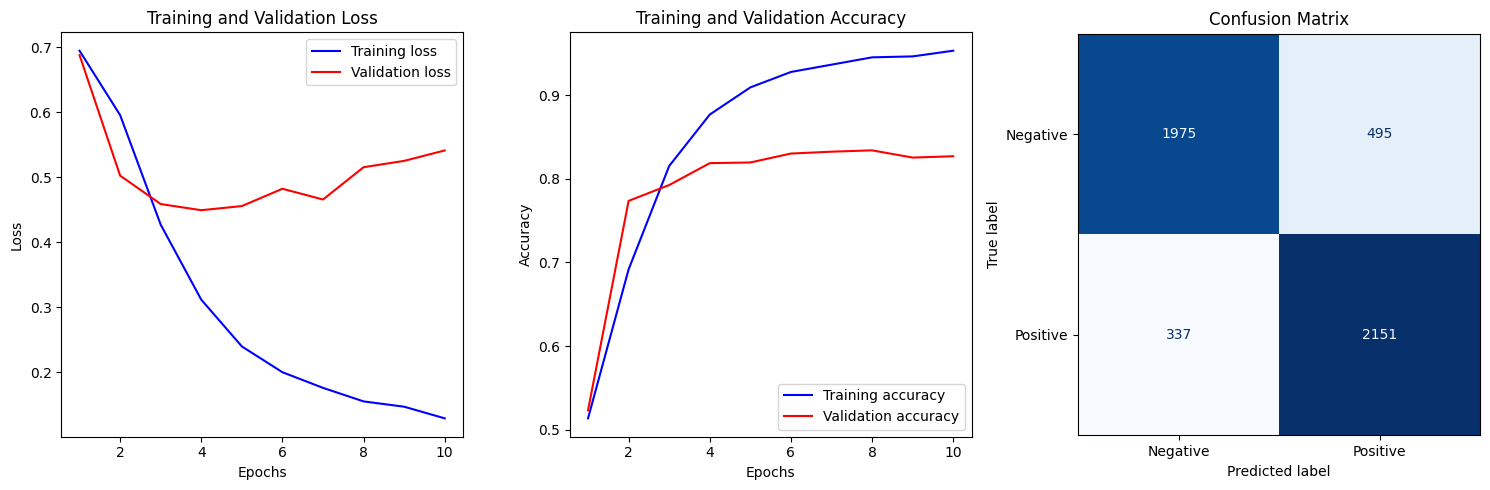

In [5]:
with torch.no_grad():
    test_loss, test_accuracy = calc_loss_and_acc(model,optimizer,test_loader,criterion,device,train=False)
    f1, recall, precision, confusion_mat = calc_acc_metrics(model, test_loader, device)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}")
plot_metrics(train_losses, valid_losses, train_accs, valid_accs, confusion_mat)

# Final Thoughts

## Overfitting
The model is clearly overfitting, which could be addressed by increasing the dropout rate or implementing regularization. However, these methods, while potentially effective, would likely be less impactful than utilizing a more sophisticated pre-trained tokenizer (e.g., GPT-2, BERT).

## Tokenizer bottleneck
As outlined in the README, a custom tokenizer was used for learning purposes. This approach provided valuable insights into the tokenization process and its effects on model performance. While the results are satisfactory given the project's learning objectives, there is clear room for improvement.

## Potential Improvement
- Exploring different model architectures that might be better suited to the task. (Transformers)
- Increasing the dataset size or employing data augmentation techniques.
